In [1]:
import sys, os, pygmt, importlib, re
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor
from datetime                   import timedelta, date, datetime
from pathlib                    import Path
from dask.distributed           import Client, LocalCluster
import numpy                    as np
import pandas                   as pd
import xarray                   as xr
import xesmf                    as xe
from collections                import defaultdict
import matplotlib.pyplot        as plt
from scipy.interpolate          import interp1d
from matplotlib.offsetbox       import AnchoredOffsetbox, VPacker, TextArea
import matplotlib.dates         as mdates
from pyproj                     import CRS, Transformer

In [387]:
# Import module *objects* first
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

In [18]:
sim_name        = "Roth-cf-max"
dt0_str         = "1993-01-01"
dtN_str         = "1999-12-31"
dt_rng_str      = f"{dt0_str[:4]}-{dtN_str[:4]}"
ispd_types      = ["ispd_BT"]  
ice_types       = ["FI_BT"]
daily           = True         
rolling         = True         
roll_period     = 15           
overwrite_zarr  = False                                      
overwrite_png   = False        
delete_original = False               
ispd_thresh     = 5.0e-4
ispd_str        = f"{ispd_thresh:.1e}".replace("e-0", "e-")
smooth_FIA_days = 15
SIA_dict        = {}
SI_plot         = SeaIcePlotter(sim_name = sim_name, save_fig=True)
tit_str         = f"Sea Ice Area Southern Ocean, {dt_rng_str}, NSIDC and Station Names: {sim_name}"
P_png           = Path(SI_plot.D_graph, "timeseries", f"SIA_NSIDC_and_{sim_name}_{dt_rng_str}.png")
SI_proc         = SeaIceProcessor(sim_name = sim_name,
                                  dt0_str  = dt0_str,
                                  dtN_str  = dtN_str)

2025-06-10 09:42:31,751 - INFO - log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_Roth-cf-max.log
INFO:Roth-cf-max:log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_Roth-cf-max.log
2025-06-10 09:42:31,754 - INFO - hemisphere initialised: south
INFO:Roth-cf-max:hemisphere initialised: south
2025-06-10 09:42:32,205 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:Roth-cf-max:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-06-10 09:42:32,207 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:Roth-cf-max:Median grid cell length below -60°: 10365.7 m
2025-06-10 09:42:32,209 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:Roth-cf-max:→ Displacement                             = 0.42% of grid cell per day
2025-06-10 09:42:32,211 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:Roth-cf-max:→ Days to fully traverse one grid cell     : 

2025-06-09 10:56:34,091 - INFO - log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_visc-meth.log
INFO:visc-meth:log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_visc-meth.log
2025-06-09 10:56:34,094 - INFO - hemisphere initialised: south
INFO:visc-meth:hemisphere initialised: south
2025-06-09 10:56:34,586 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:visc-meth:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-06-09 10:56:34,591 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:visc-meth:Median grid cell length below -60°: 10365.7 m
2025-06-09 10:56:34,594 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:visc-meth:→ Displacement                             = 0.42% of grid cell per day
2025-06-09 10:56:34,596 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:visc-meth:→ Days to fully traverse one grid cell     : 239.95 days
2025

💾 Saved plot to /g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIA_NSIDC_and_visc-meth_1993-1999.png


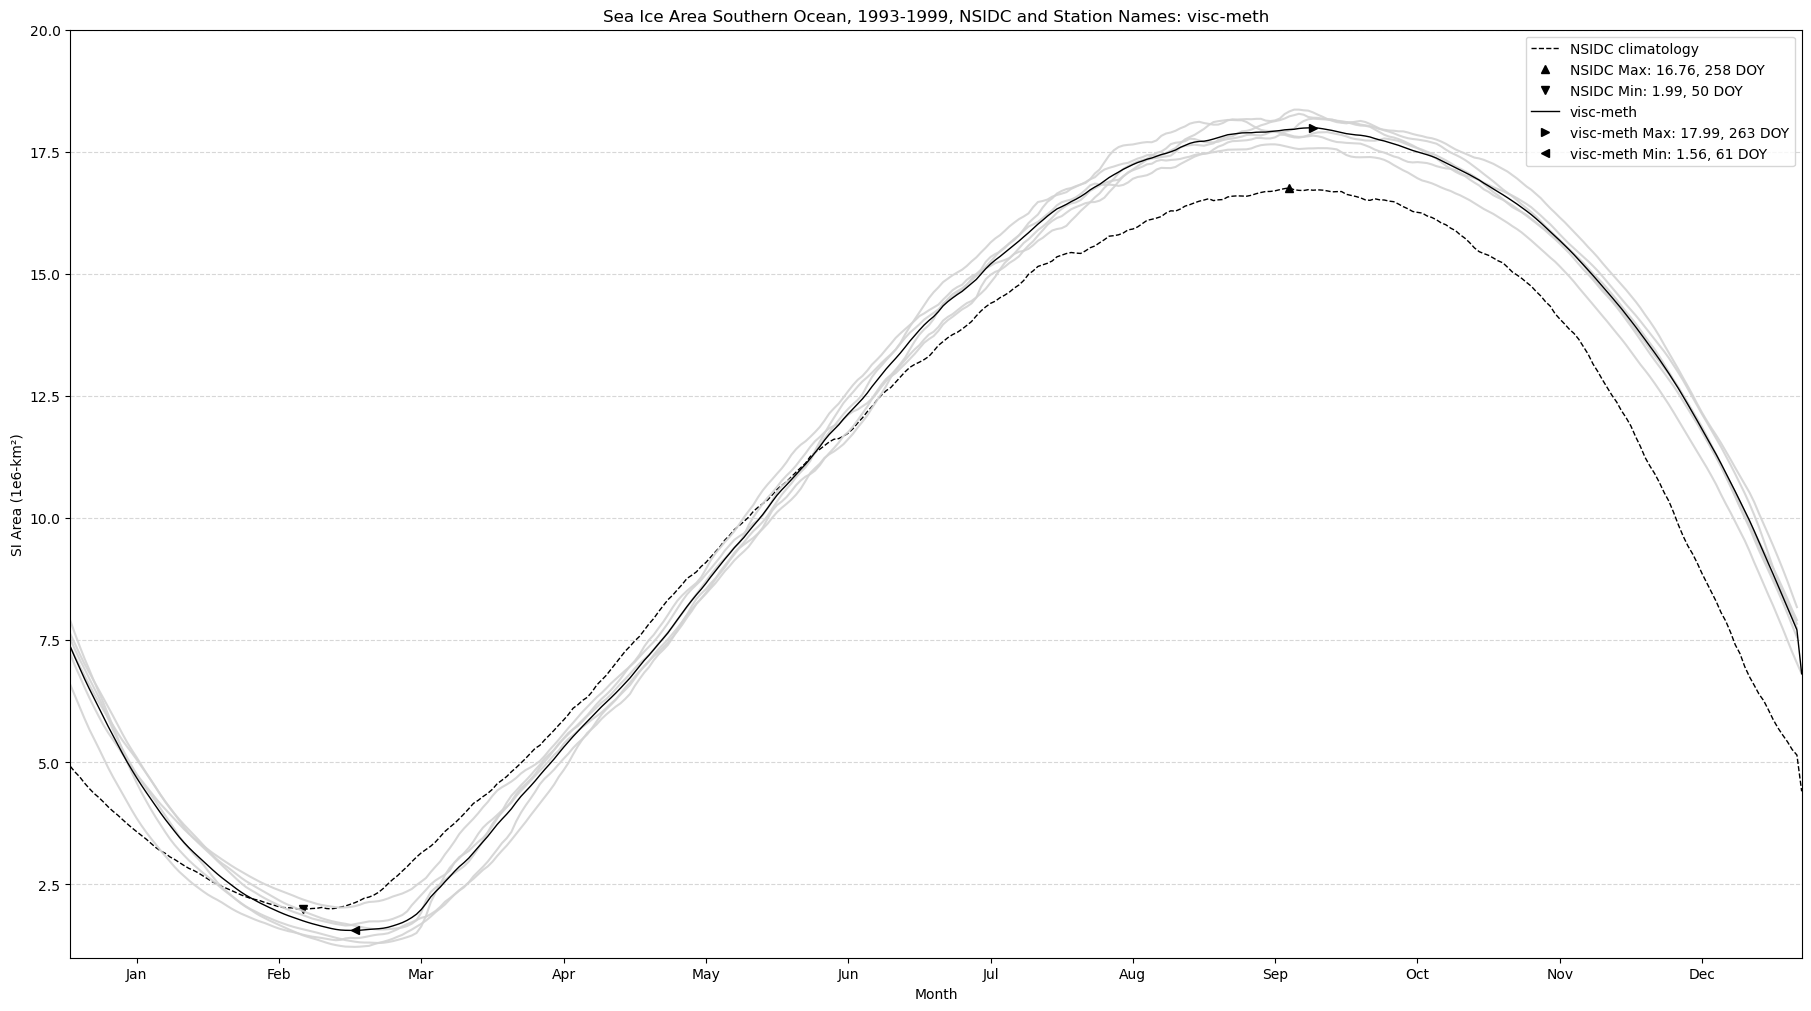

In [ ]:
#sim_names       = SI_proc.config.get('sim_dict').keys()
#SI_proc.correct_timestamp_for_all_monthly_zarr_iceh( sim_names=sim_names, dry_run=False )
SI_proc.daily_iceh_to_monthly_zarr(overwrite=overwrite_zarr, delete_original=delete_original)
NSIDC             = SI_proc.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = NSIDC['SIA']
# if daily:
#     DS_daily = SI_proc.process_daily_cice(ispd_type            = ispd_types,
#                                           overwrite_zarr_group = overwrite_zarr)
# if rolling:
#     DS_roll = SI_proc.process_rolling_cice(mean_period          = roll_period,
#                                            ispd_type            = ispd_types,
#                                            overwrite_zarr_group = overwrite_zarr)
DS, CICE_SO       = SI_proc.load_processed_cice(ispd_thresh = ispd_thresh,
                                          ice_type    = ice_types[0],
                                          zarr_CICE   = True,
                                          rolling     = True if ice_types[0]==f"{ice_types[0]}_roll" else False,
                                          slice_hem   = True)
SIA_dict[sim_name] = SI_proc.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_proc.SIC_scale)
SI_plot.plot_monthly_ice_area_by_year(SIA_dict,
                                      ice_type = "SI",
                                      tit_str  = tit_str,
                                      P_png    = P_png,
                                      ylim     = (1,20))

In [19]:
ice_type                 = "FI_BT"
ispd_thresh_str          = f"{ispd_thresh:.1e}".replace("e-0", "e-")
D_out                    = Path(SI_proc.D_zarr, f"ispd_thresh_{ispd_thresh_str}", "metrics")
FIA_dict                 = {}
af2020_df                = pd.read_csv(SI_proc.sea_ice_dict['P_AF2020_cli_csv'])
FIA_dict["AF2020db_cli"] = SI_proc.interpolate_obs_fia(af2020_df)
ice_types                = [ice_type, f"{ice_type}_roll", f"{ice_type}_bool"]
for i_type in ice_types:
    P_METS = Path(D_out, f"{i_type}_mets.zarr")
    P_sum  = Path(D_out, f"{i_type}_summary.csv")
    if P_METS.exists() and not overwrite_zarr:
        print(f"{P_METS} exists and not overwriting--loading")
        METS             = xr.open_zarr(P_METS)
        FIA_dict[i_type] = METS['FIA']
    else:
        print(f"{P_METS} does NOT exists and/or overwriting--computing")
        roll = i_type.endswith("_roll")
        DS, CICE_SO = SI_proc.load_processed_cice(ispd_thresh = ispd_thresh,
                                                  ice_type    = ice_type,
                                                  zarr_CICE   = True,
                                                  rolling     = roll,
                                                  slice_hem   = True)
        if i_type==f"{ice_type}_bool":
            bool_mask          = SI_proc.boolean_fast_ice(DS['FI_mask'], dim="time", window=7, min_count=6)
            DS_bool            = CICE_SO.where(bool_mask)
            DS_bool["FI_mask"] = DS["FI_mask"]
            DS                 = DS_bool
        METS = SI_proc.compute_sea_ice_metrics(DS, sim_name, i_type, ispd_thresh_str, P_METS, P_sum, FIA_dict["AF2020db_cli"])
    FIA_dict[i_type] = METS['FIA']

/g/data/gv90/da1339/afim_output/Roth-cf-max/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr exists and not overwriting--loading
/g/data/gv90/da1339/afim_output/Roth-cf-max/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr exists and not overwriting--loading
/g/data/gv90/da1339/afim_output/Roth-cf-max/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr exists and not overwriting--loading


In [20]:
SI_proc.sim_config

{'dt': '1800.00',
 'ndtd': '1',
 'ndte': '240',
 'kdyn': '1',
 'revised_evp': 'T',
 'e_yieldcurve': '2.00',
 'e_plasticpot': '2.00',
 'Ktens': '0.20',
 'kstrength': '1',
 'Pstar': '',
 'Cstar': '',
 'Cf': '24.00',
 'visc_method': '',
 'kmt_file': 'kmt_mod_thinned-0p75_v1p50.nc',
 'GI_thin_fact': 0.75,
 'GI_version': 1.5}

📏 Saved plot to /g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_AF2020db_and_Roth-cf-max_1993-1999.png


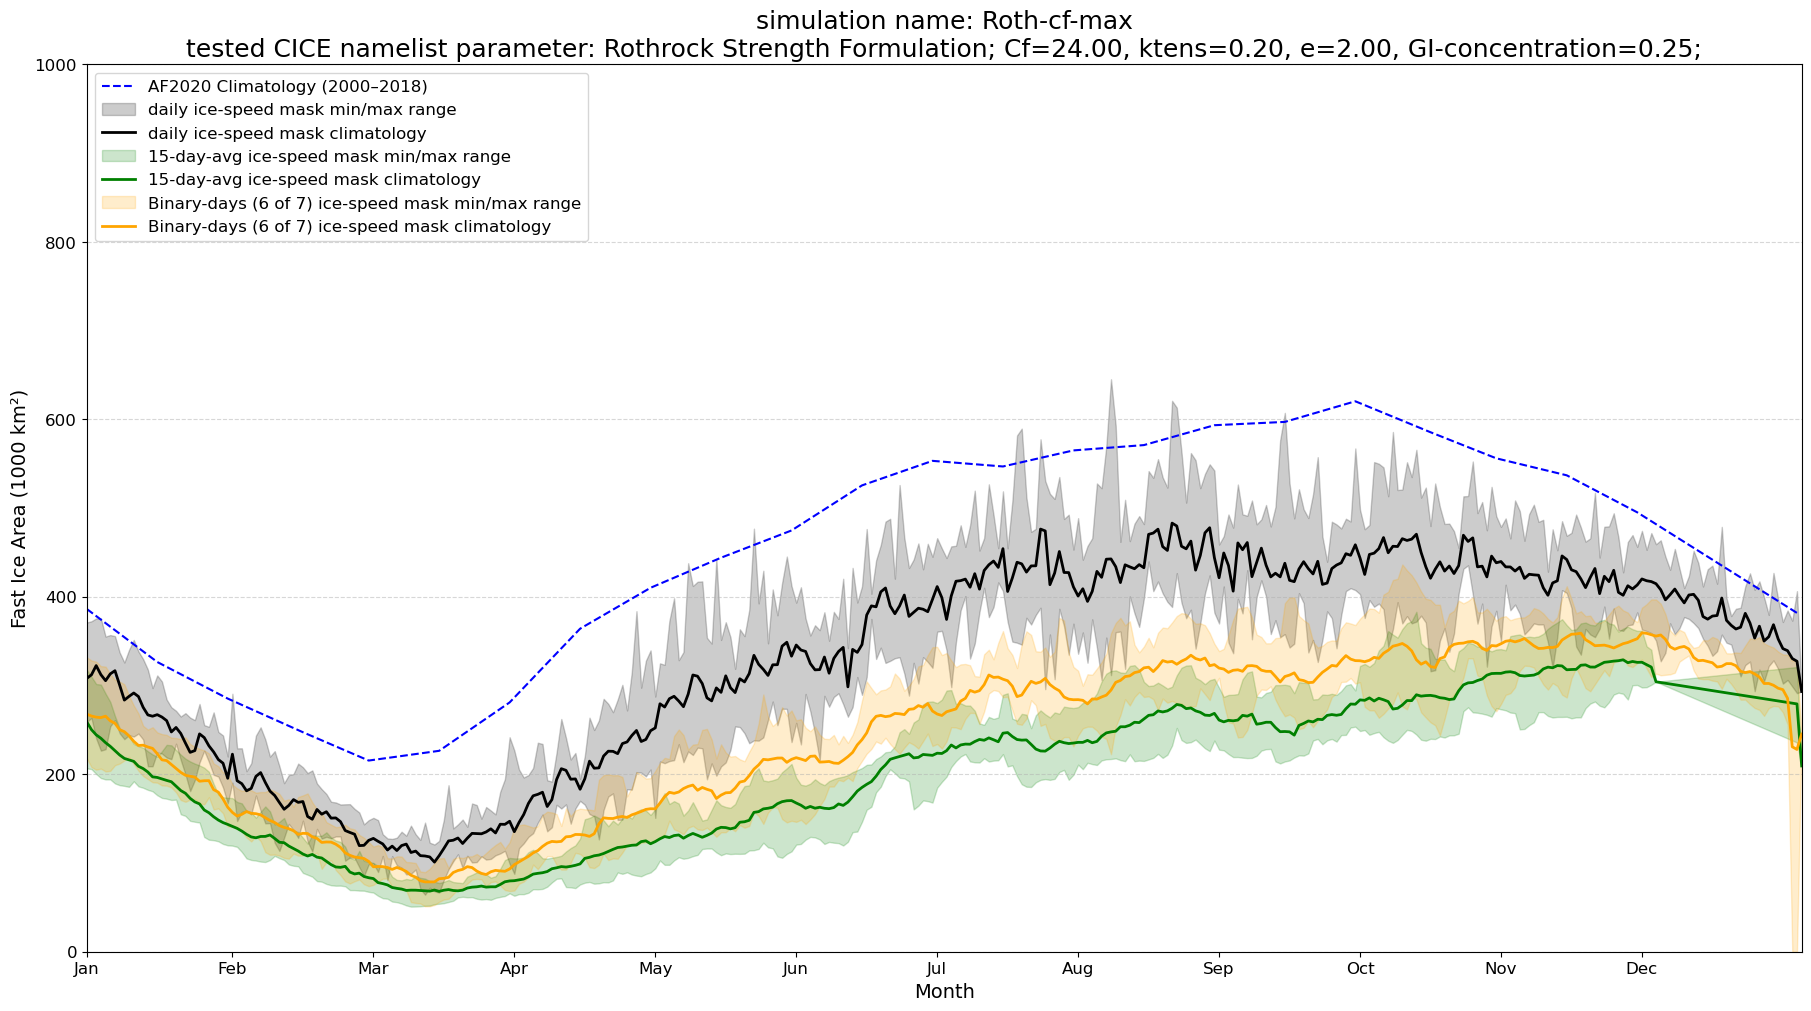

In [21]:
#FIA_dict[sim_name]       = SI_proc.compute_ice_area(DS['aice'], DS['tarea']).compute()
#tit_str = f"Fast Ice Area Southern Ocean, {dt_rng_str}, AF2020db Climatology and Station Names: {sim_name}"
ktens    = SI_proc.sim_config['Ktens']
elps     = SI_proc.sim_config['e_yieldcurve']
ndte     = SI_proc.sim_config['ndte']
Cf       = SI_proc.sim_config['Cf']
GI_thin  = 1 - SI_proc.sim_config['GI_thin_fact']
#Pstar = float(SI_proc.sim_config['Pstar'].replace("D", "E"))
tit_str  = f"simulation name: {sim_name}\ntested CICE namelist parameter: Rothrock Strength Formulation; Cf={Cf}, ktens={ktens}, e={elps}, GI-concentration={GI_thin:0.2f};"
P_png    = Path(SI_plot.D_graph, "timeseries", f"FIA_AF2020db_and_{sim_name}_{dt_rng_str}.png")
SI_plot.plot_monthly_ice_area_by_year(FIA_dict,
                                      ice_type = "FI",
                                      tit_str  = tit_str,
                                      P_png    = P_png)

In [194]:
def plot_east_west_persistence_map(DA,
                                   lon_coord_name = "TLON",
                                   lat_coord_name = "TLAT",
                                   tit_str        = "Fast Ice Persistence",
                                   ispd_str       = None,
                                   ice_type       = None,
                                   sim_name       = None,
                                   plot_GI        = False,
                                   dt_range_str   = None,
                                   overwrite_png  = False,
                                   show_fig       = False):
    """
    Plot two regional panels (East and West Antarctic coastlines) in cylindrical projection
    with 'north up', showing fast ice persistence.

    Each region is manually specified and plotted side-by-side.
    """
    sim_name = sim_name if sim_name is not None else SI_proc.sim_name
    if plot_GI:
        from grounded_iceberg_processor import GroundedIcebergProcessor
        GI_proc   = GroundedIcebergProcessor(sim_name=self.sim_name)
        G_t       = GI_proc.align_modified_landmask()
        GI_coords = (G_t['GI_lon'], G_t['GI_lat'])
    else:
        GI_coords = None
    da   = DA.values.ravel()
    lon  = DA[lon_coord_name].values.ravel()
    lat  = DA[lat_coord_name].values.ravel()
    mask = (~np.isnan(da)) & (da > 0)
    lat_plt, lon_plt, da_plt = lat[mask], lon[mask], da[mask]
    cmap      = SI_plot.pygmt_dict.get("FIP_CPT")
    cmap_ser  = [0.01, 1.0, 0.01]
    cbar_lab  = "Fast Ice Persistence"
    region_E  = [-20, 160, -73, -62]   # East Antarctic coastline (longitudes west of 0°)
    region_W  = [160, 340, -79, -61]   # West Antarctic coastline (longitudes east of 0°)
    proj      = "M20c"
    D_plt = Path(SI_plot.D_graph, sim_name, "Two_Antarctic_Sectors")
    D_plt.mkdir(parents=True, exist_ok=True)
    P_plt = D_plt / f"FIP_EW_{dt_range_str}.png"
    if P_plt.exists() and not overwrite_png:
        print(f"figure {P_plt} exists and not overwriting")
        return
    fig = pygmt.Figure()
    pygmt.makecpt(cmap=cmap, series=cmap_ser, continuous=True)
    fig.basemap(region=region_E, projection=proj, frame=["af"])#, f"+tWest Antarctic"])
    fig.plot(x=lon_plt, y=lat_plt, fill=da_plt, style="s0.2c", cmap=True)
    if GI_coords:
        fig.plot(x=GI_coords[0], y=GI_coords[1], fill="red", style="c0.2c")
    #fig.coast(land="darkgray")#,shorelines=".2p,black")
    fig.shift_origin(yshift="-8c")  # shift down
    fig.basemap(region=region_W, projection=proj, frame=["af"])#, f"+tEast Antarctic"])
    #fig.coast(land="seashell", water="white", shorelines=".2p,gray")
    fig.plot(x=lon_plt, y=lat_plt, fill=da_plt, style="s0.2c", cmap=True)
    if GI_coords:
        fig.plot(x=GI_coords[0], y=GI_coords[1], fill="red", style="c0.2c")
    #fig.coast(land='darkgray')#,shorelines=".2p,black")
    fig.colorbar(position="JBC+w10c/0.5c+mc+h", frame=[f"x+l{cbar_lab}", "y+l1/100"])
    # Save/show
    #print(f"📸 Saving figure: {P_plt}")
    #fig.savefig(P_plt)
    #if show_fig:
    fig.show()

In [365]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

def load_gmt_cpt(cpt_path):
    """
    Load a continuous GMT .cpt file with 8-column format:
    <val1> R1 G1 B1 <val2> R2 G2 B2
    Normalizes to [0, 1] for use with matplotlib LinearSegmentedColormap.
    """
    import matplotlib.colors as mcolors
    import numpy as np
    red, green, blue = [], [], []
    raw_vals = []
    # First pass: extract all val1, val2 for normalization
    with open(cpt_path, "r") as f:
        for line in f:
            if not line.strip() or line.startswith(("#", "B", "F", "N")):
                continue
            parts = line.strip().split()
            if len(parts) != 8:
                continue
            try:
                val1 = float(parts[0])
                val2 = float(parts[4])
                raw_vals.extend([val1, val2])
            except ValueError:
                continue
    if len(raw_vals) < 2:
        raise ValueError("CPT file is empty or malformed.")
    vmin, vmax = min(raw_vals), max(raw_vals)
    norm_range = lambda x: (x - vmin) / (vmax - vmin)
    # Second pass: construct normalized color dict
    with open(cpt_path, "r") as f:
        for line in f:
            if not line.strip() or line.startswith(("#", "B", "F", "N")):
                continue
            parts = line.strip().split()
            if len(parts) != 8:
                continue
            try:
                val1 = float(parts[0])
                r1, g1, b1 = map(int, parts[1:4])
                val2 = float(parts[4])
                r2, g2, b2 = map(int, parts[5:8])
                x0 = norm_range(val1)
                x1 = norm_range(val2)
                red.append((x0, r1/255, r1/255))
                red.append((x1, r2/255, r2/255))
                green.append((x0, g1/255, g1/255))
                green.append((x1, g2/255, g2/255))
                blue.append((x0, b1/255, b1/255))
                blue.append((x1, b2/255, b2/255))
            except Exception as e:
                print(f"⚠️ Skipping line: {line.strip()} ({e})")
                continue
    cdict = {"red": red, "green": green, "blue": blue}
    cmap = mcolors.LinearSegmentedColormap("custom_cpt", cdict)
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
    return cmap, norm

def plot_east_west_persistence_map_cartopy(DA,
                                           sim_name       = None,
                                            lon_coord_name = "TLON",
                                            lat_coord_name = "TLAT",
                                            tit_str        = "Fast Ice Persistence",
                                            ispd_str       = None,
                                            ice_type       = None,
                                            plot_GI        = False,
                                            dt_range_str   = None,
                                            overwrite_png  = False,
                                            show_fig       = False,
                                            vmin           = 0.01,
                                            vmax           = 1.0):
    """
    Cartopy version: Plot East and West Antarctic sectors in cylindrical projection (north-up)
    using pcolormesh instead of scatter.
    """
    sim_name   = sim_name if sim_name is not None else SI_proc.sim_name
    D_plt = Path(SI_proc.D_dict['graph'],sim_name,"Two_Antarctic_Sectors")
    D_plt.mkdir(parents=True, exist_ok=True)
    P_plt      = Path(D_plt, f"FIP_EW_{dt_range_str}.png")
    cpt_path   = Path.home() / "graphical/CPTs/AF2020_YlGnBu.cpt"
    cmap, norm = load_gmt_cpt(cpt_path)
    print("🎨 CPT colormap loaded with", cmap.N, "colors")
    region_E   = [20, 175, -79, -62]
    region_W   = [-162, 20, -79, -61]
    DA_masked  = DA.where((DA > 0) & np.isfinite(DA))
    lon2d      = DA_masked[lon_coord_name].values
    lat2d      = DA_masked[lat_coord_name].values
    val2d      = DA_masked.values
    if plot_GI:
        G_t     = SI_proc.define_cice_grid(grid_type='t').isel(nj=slice(0,540))
        kmt_mod = xr.open_dataset(SI_proc.P_KMT_mod).isel(nj=slice(0,540)).kmt.data
        kmt_org = xr.open_dataset(SI_proc.P_KMT_org).isel(nj=slice(0,540)).kmt.data
        Glat    = G_t['lat'].data
        Glon    = G_t['lon'].data
        GI_mask = (kmt_org == 1) & (kmt_mod == 0)
        GI_lon  = lon2d[GI_mask]
        GI_lat  = lat2d[GI_mask]
    fig, axes = plt.subplots(nrows=2, figsize=(17,12), subplot_kw={'projection': ccrs.Mercator(min_latitude=-80, max_latitude=-60)})
    fig.suptitle(f"{sim_name}", fontsize=16) 
    for ax, region, title in zip(axes, [region_E, region_W], ["East Antarctic", "West Antarctic"]):
        ax.set_extent(region, crs=ccrs.PlateCarree())
        ax.set_aspect("auto")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['geo'].set_visible(False)
        ax.coastlines(resolution='10m', linewidth=0.1)
        ax.add_feature(cfeature.LAND, color='lightgray')
        pcm = ax.pcolormesh(lon2d, lat2d, val2d, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())
        if plot_GI:
            ax.scatter(GI_lon, GI_lat, color="red", s=.25, transform=ccrs.PlateCarree())
    fig.subplots_adjust(hspace=0.05)
    cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), orientation='horizontal', shrink=0.8, pad=0.05, label="Fast Ice Persistence (1/100)")
    print(f"📸 Displaying Cartopy figure (pcolormesh): {P_plt.name}")
    #if show_fig:
    plt.show()
    plt.close(fig)

🎨 CPT colormap loaded with 256 colors
📸 Displaying Cartopy figure (pcolormesh): FIP_EW_None.png


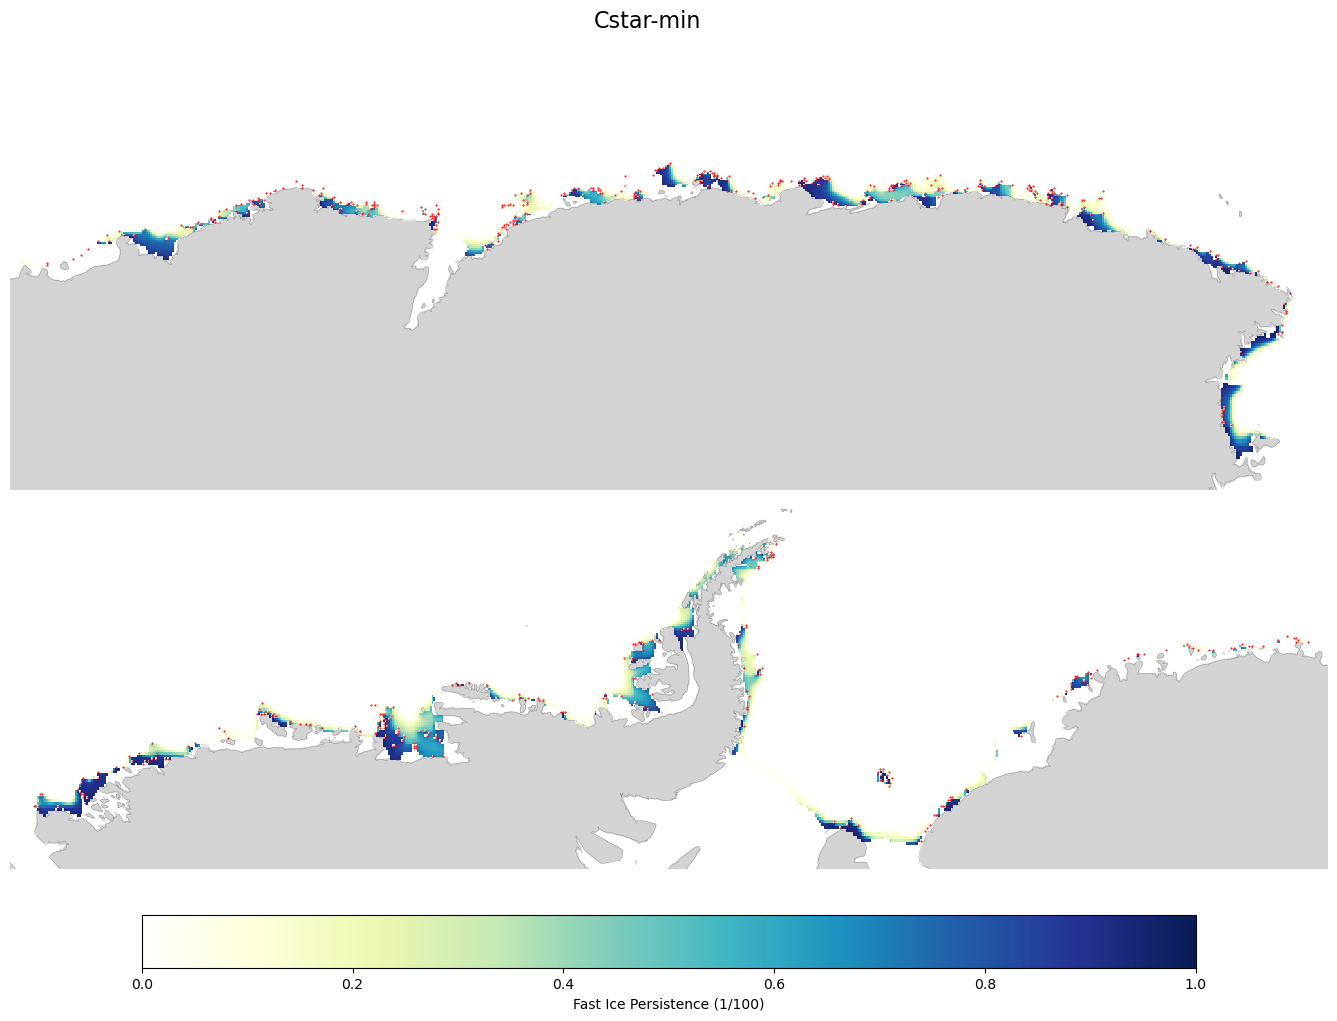

In [366]:
plot_east_west_persistence_map_cartopy(METS['FIP'], plot_GI=True)
#plot_east_west_persistence_map(METS['FIP'])

In [213]:
METS['FIP'].max().values

array(0.95972455, dtype=float32)